# Assignment — Cascades and influence maximization

In [102]:
from matplotlib.animation import FuncAnimation
import numpy as np
from zlib import adler32
import networkx as nx
import matplotlib.pyplot as plt
import random
from IPython.display import HTML
from scipy.sparse import csgraph
from numpy import linalg
from networkx.algorithms.centrality import degree_centrality , betweenness_centrality ,eigenvector_centrality
import math

This part of the assignment is devoted to models of influence propagation: the linear threshold model and independent cascade model. There are many applications of these types of models, for example:
* Rise of a political movement in an unstable society
* “Word-of-mouth” effects: when we have access to plentiful information, such as when we evaluate new technologies, risky financial assets, or job candidates, we often lack the ability to make sense of it; hence, we rely on the advice of trusted friends, colleagues, or advisors
* “Viral marketing” effects in the success of new products
* Adoption of medical and agricultural innovations
* Cascading failures in power systems
* Desicion making by majority voting

Let us consider these models on directed Erdos Renyi graph.

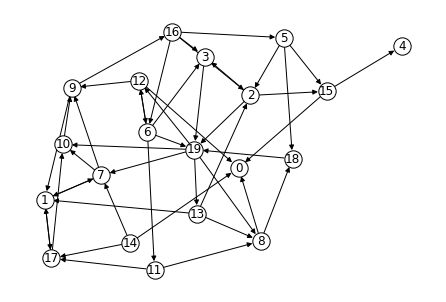

In [83]:
n = 20
G = nx.erdos_renyi_graph(n, 0.11, 0, True)

plt.figure(figsize=(6, 4))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, node_color='white', edgecolors='black')

### Task 1. Linear threshold model (2 points)

Linear threshold model is defined as follows. Given a choice of all nodes’ thresholds, and an initial set of active nodes, the diffusion process unfolds deterministically in discrete steps: in step $t$, all nodes that were
active in step $t-1$ remain active; furthermore, each currently inactive node becomes active if and only
if the total share of its active neighbors is at least node's threshold.

Write a function `linear_threshold` that takes a graph, np.array `active_nodes` with zeros and ones (if `active_nodes[i]` is 1 then the i-th node is active), np.array of `thresholds`. The function propagates influence and stops when the model stops changing. The function returns a np.array with active nodes in each step. The first step is initial activation, the last and the second to last steps are the same (we want to see that the propogation stops changing).

In [84]:
from networkx.classes.function import non_neighbors
def linear_threshold(G, active_nodes, thresholds):
    #tmp_active_nodes = np.copy(active_nodes)
    n = len(active_nodes)
    output = []
    #append initial case 
    output.append(active_nodes.copy())
    an_array = active_nodes.copy()
    break_var = True
    while(break_var):
      tmp_active_nodes = np.zeros(n)
      for node in range(0,n):
        #active nodes remain active
        if (an_array[node] == 1):
          tmp_active_nodes[node] = 1
        #inactive nodes 
        else:
          tmp_sum = 0 
          n_neighbors = 0
          for nigh_node in G.predecessors(node):
            n_neighbors = n_neighbors +1
            if(an_array[nigh_node] == 1):
              tmp_sum = tmp_sum +1
          share = 0 
          if n_neighbors!= 0:
            share = tmp_sum /n_neighbors 
          #else:

          #either become active > threshold
          if (share >= thresholds[node]):
            tmp_active_nodes [node] = 1
          #or remain inactive
          else:
            tmp_active_nodes [node] = 0
        
      if (np.array_equal(an_array, tmp_active_nodes)):
        break_var = False
        #output.append(tmp_active_nodes.copy())
      for node in range(0,n):
         an_array[node] = tmp_active_nodes[node]
      output.append(an_array.copy())
    return np.array(output)

    # YOUR CODE HERE
    #raise NotImplementedError()

In [85]:
np.random.seed(5)
active_nodes = np.zeros(n, 'int')
active_nodes[np.random.choice(np.arange(n), 2, False)] = 1
thresholds = np.random.uniform(0.5, 1, n)

sim = linear_threshold(G, active_nodes, thresholds)

assert sim.shape == (4, 20)
assert np.all(sim[0] == active_nodes)
assert np.all(sim[-1] == sim[-2])
assert sim[0, 4] == 0
assert sim[2, 4] == 1
assert sim[0, 3] == 0
assert sim[1, 15] == 1

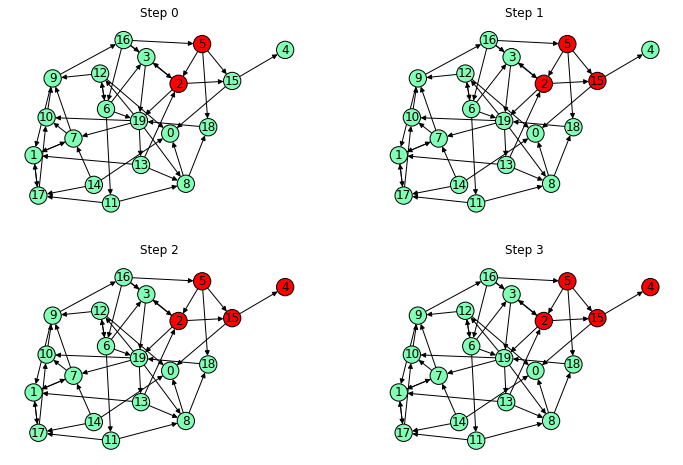

In [86]:
plt.figure(figsize=(6*2, 4*2))

for i, color in enumerate(sim):
    plt.subplot(2, 2, i+1)
    nx.draw(G, pos, with_labels=True, 
            node_color=color+1, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    plt.title('Step {}'.format(i))
plt.show()

### Task 2. Independent cascade model (2 points)

The next type is Independent cascade model. We again start with an initial set of active nodes, and the process unfolds in discrete steps according to the following randomized rule. When node $v$ first becomes active in step $t$, it is given a single chance to activate each currently inactive neighbor $w$; it succeeds with a probability $p_{v,w}$ — a parameter of the system — independently of the history thus far. (If $w$ has multiple newly activated neighbors, their attempts are sequenced in an arbitrary order.) If $v$ succeeds, then $w$ will become active in step $t+1$; but whether or not $v$ succeeds, it cannot make any further attempts to activate $w$ in subsequent steps.

Write a function `independent_cascade` that takes a graph, np.array active_nodes with zeros and ones (if active_nodes[i] is 1 then the i-th node is active), np.array with propagation probabilities `prop_proba` for edges ordered by `G.edges`. The function propagates influence and stops when the model stops changing. The function returns a np.array with active nodes in each step. The first step is initial activation, the last and the second to last steps are the same (we want to see that the model stops changing).

In [87]:
def independent_cascade(G, active_nodes, prop_proba):
    edges_tuple_list  =[]
    #get tuple of edges
    index = 0 
    for n1,n2 in G.edges:
      edges_tuple_list.append ((index , n1 ,n2 ,prop_proba[index]))
      index = index +1
    output = []
    n = len(active_nodes)
    output.append (active_nodes.copy())
    an_array = active_nodes.copy()
    
    #informed _dict 
    informed_dict = {n : [] for n in G.nodes}
    break_var = True
    while(break_var):
      tmp_active_nodes = np.zeros(n)
      for node in G.nodes:
        if an_array[node] == 1:
          tmp_active_nodes[node] = 1
          # that means that it has a probability to activate nighbores 
          #get list of edges 
          for nigh_node in G.successors(node):
            if node not in informed_dict[nigh_node] and an_array[nigh_node] == 0:
              for t in edges_tuple_list:
                if ((t[1]== node and t[2]== nigh_node)or (t[2]== node and t[1]== nigh_node)):
                  informed_dict[nigh_node].append(node)
                  if (random.random() < t[3]):
                    tmp_active_nodes[nigh_node] = 1
                  else:
                    tmp_active_nodes[nigh_node] = 0
                  break
      
      if (np.array_equal(an_array, tmp_active_nodes)):
        break_var = False
      for node in range(0,n):
         an_array[node] = tmp_active_nodes[node]
      output.append(an_array.copy())
    return np.array(output)

    # YOUR CODE HERE
    #raise NotImplementedError()

In [88]:
np.random.seed(1)
active_nodes = np.zeros(20, 'int')
active_nodes[np.random.choice(np.arange(20), 2, False)] = 1
prop_proba = np.random.rand(len(G.edges))

sims = []
n_steps = []
for i in range(1000):
    sim = independent_cascade(G, active_nodes, prop_proba)
    sims.append(sim)
    n_steps.append(len(sim))
sigma = 1.9165
mean = 5.103
assert mean - 2*sigma < np.mean(n_steps) < mean + 2*sigma
sim = sims[n_steps.index(6)]
assert sim.shape == (6, 20)
assert np.all(sim[0] == active_nodes)
assert np.all(sim[-1] == sim[-2])
for i in range(1, 4):
    attempts = sim[i] - sim[i-1]
    new_active = sim[i+1] - sim[i]
    has_edge = False
    for j in np.argwhere(attempts == 1):
        for k in np.argwhere(new_active == 1):
            if G.has_edge(j[0], k[0]):
                has_edge = True
    assert has_edge

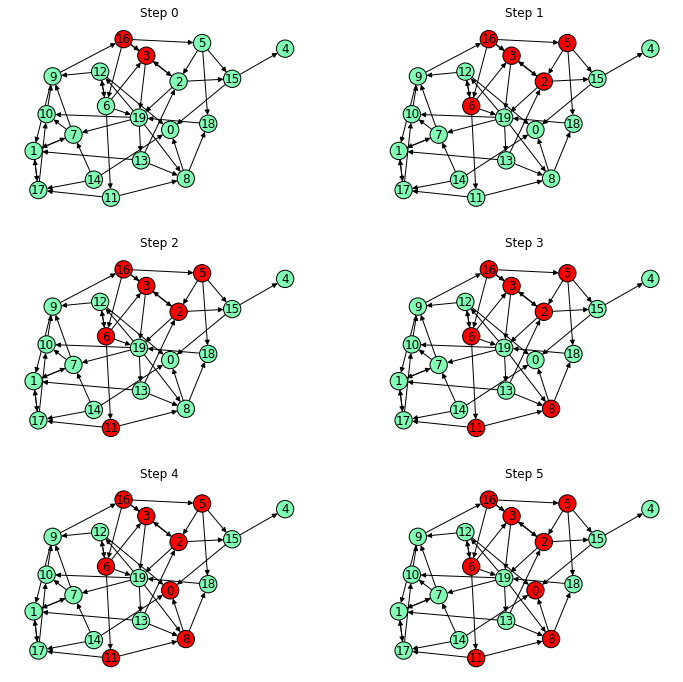

In [89]:
plt.figure(figsize=(6*2, 4*3))

for i, color in enumerate(sim):
    plt.subplot(3, 2, i+1)
    nx.draw(G, pos, with_labels=True, 
            node_color=color+1, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    plt.title('Step {}'.format(i))
plt.show()

### Task 3. Influence maximization problem (2 points)

The influence is the expected number of active nodes at the end of the process

$$\sigma(A_0) = \mathbb E[|A_t|]$$

where $A_0$ is an initial active nodes and $A_t$ is an active nodes at the end. Linear threshold model is deterministic and then $E[|A_t|] = |A_t|$.

The influence maximization problem asks, for a given number of initial active nodes $k$, to find a set of nodes that gives maximum influence. It is NP-hard problem, but a useful property is that it can be solved in polynomial time by greedy optimization with guaranteed performance slightly better than 63%. Proofs are [here](https://theoryofcomputing.org/articles/v011a004/v011a004.pdf). The algorithm is:

1. Let $A_0 = \emptyset$
2. For every node $i$, calculate the influence $\sigma(A_0 \cup \{i\})$
3. Put the node with the largest influence into the initial active set $A_0 = A_0 \cup \{i\}$
4. Repeat 2-3 until $|A_0| = k$

Write a function `greedy_influence_max` that takes a graph, `thresholds` of linear threshold model, number of active nodes `k` and calculates initial active nodes by greedy algorithm. The function returns a np.array with zeros and ones (if `active_nodes[i]` is 1 then the i-th node is active).

In [90]:
def greedy_influence_max(G, thresholds, k):
    n = len(G.nodes)
    active_nodes = np.zeros(n)
    #tmp_active_nodes = active_nodes.copy()
    maxeffect = 0 
    max_node = -1
    while (np.sum(active_nodes) != k):
      for node in range(0 , n ):
        tmp_active_nodes = active_nodes.copy()
        if (tmp_active_nodes[node] == 0):
          tmp_active_nodes[node] =1
          output = linear_threshold(G,tmp_active_nodes , thresholds)
          effect = np.sum(output[-1])
          if (maxeffect< effect):
            maxeffect = effect
            max_node = node
      active_nodes[max_node] = 1
    return active_nodes

    # YOUR CODE HEREn
    #raise NotImplementedError()

In [91]:
n = 100
G = nx.erdos_renyi_graph(n, 0.07, 0, True)

np.random.seed(0)
active_nodes = np.zeros(n, 'int')
active_nodes[np.random.choice(np.arange(n), 2, False)] = 1
thresholds = np.random.uniform(0.1, 0.8, n)

best_active = greedy_influence_max(G, thresholds, 2)
assert best_active.shape == (100,)
assert best_active.sum() == 2
sim = linear_threshold(G, best_active, thresholds)
assert sim[-1].sum() > 21 * 0.63

Here is the same model as in the linear threshold task, but with a better initial active set.

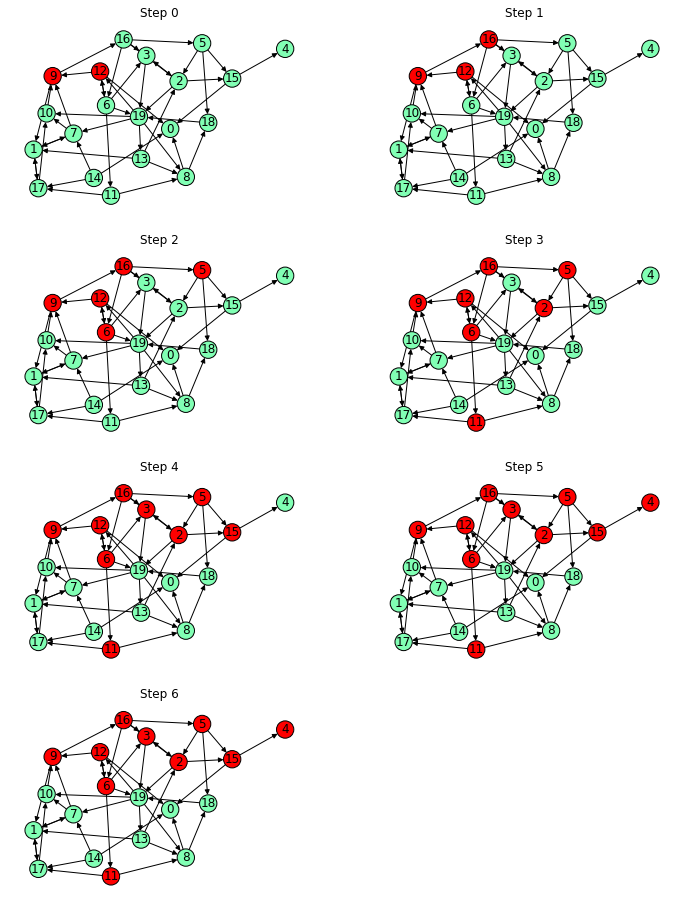

In [92]:
n = 20
G = nx.erdos_renyi_graph(n, 0.11, 0, True)

np.random.seed(5)
active_nodes = np.zeros(n, 'int')
active_nodes[np.random.choice(np.arange(n), 2, False)] = 1
thresholds = np.random.uniform(0.5, 1, n)

best_active = greedy_influence_max(G, thresholds, 2)
sim = linear_threshold(G, best_active, thresholds)

plt.figure(figsize=(6*2, 4*4))

for i, color in enumerate(sim):
    plt.subplot(4, 2, i+1)
    nx.draw(G, pos, with_labels=True, 
            node_color=color+1, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    plt.title('Step {}'.format(i))
plt.show()

### Task 4. Diffusion on networks (2 points)

A diffusion process is a propagation model, where node values $\phi$ (say, 'heat') spread out of high concentration zone. Consider the diffusion on grid of the size 20x20. Let there be a 3x3 sub-grid with a heat value 3 and a 7x5 sub-grid with a heat value 1. All other nodes has a value 0. The initial heat values is $\phi_0$.

In [93]:
phi_map = np.zeros((20, 20))
phi_map[1:4, 1:4] = 3
phi_map[10:15, 8:15] = 1
phi0 = phi_map.flatten()

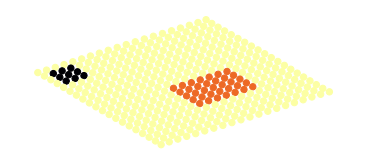

In [94]:
plt.figure(figsize=(7*0.7, 3*0.7))
gridG = nx.grid_graph((20, 20))
nx.draw_kamada_kawai(
    gridG,
    cmap=plt.cm.inferno_r,
    vmin=0, vmax=3,
    width=0,
    node_size=40,
    node_color=phi0)

Create a diffusion simulation based on this diffusion equation

$$\frac{d\phi}{dt} = -CL\phi$$

where $L$ is a graph Laplacian.

Write a function `next_phi` that takes an adjacency matrix `A`, np.array with previous heat values `phi`, constant `C` and time increment `dt`. The function returns a np.array with the next heat values.

In [95]:
def next_phi(A, phi, C, dt):
    #G= nx.from_numpy_matrix(A)
    #L = nx.laplacian_matrix(G)
    L =  csgraph.laplacian(A, normed=False)
    new_const = -1 * C*dt
    dphi = np.multiply(new_const, np.dot(L ,phi))
    return np.add(phi, dphi)
    # YOUR CODE HERE
    #raise NotImplementedError()

In [96]:
A = nx.to_numpy_array(gridG)
C = 0.1
dt = 2
phi = next_phi(A, phi0, C, dt)
assert phi.shape == (400,)
assert phi.sum() == phi0.sum()
assert phi.std() < phi0.sum()
assert round(phi[20:25].sum(), 4) == 7.2

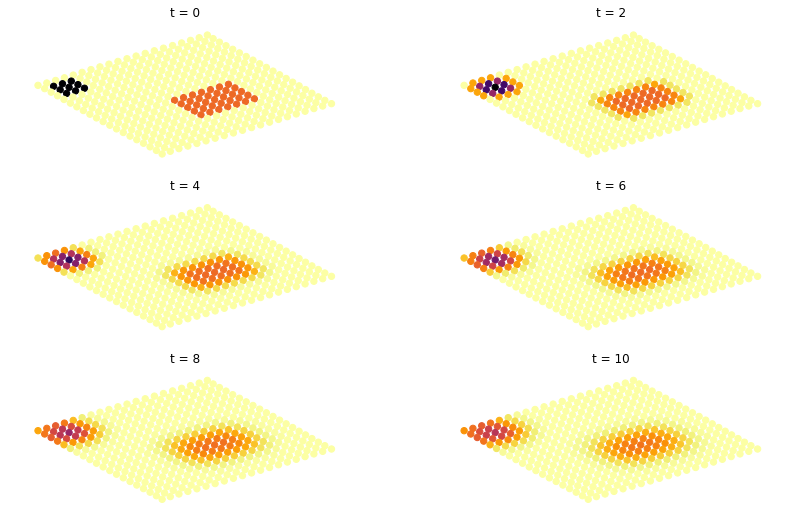

In [97]:
plt.figure(figsize=(7*2, 3*3))

phi = phi0
for i in range(6):
    plt.subplot(3, 2, i+1)
    gridG = nx.grid_graph((20, 20))
    nx.draw_kamada_kawai(
        gridG,
        cmap=plt.cm.inferno_r,
        vmin=0, vmax=3,
        width=0,
        node_size=40,
        node_color=phi)
    plt.title('t = {}'.format(i*dt))
    phi = next_phi(A, phi, C, dt)
phi12 = phi

We can run simulation step-by-step as long as we need, but fortunately, there is an analytical solution

$$\phi(t) = \sum_k a_k(t) v_k = \sum_k a_k(0) e^{-C\lambda_k t} v_k$$

where $a_k(t) = \phi(t)^T v_k$ and $v_k$ is k-th smallest eigenvector of a Laplacian.

Write a function `phi_t` that takes an adjacency matrix `A`, np.array with initial heat values `phi0`, constant `C` and time moment `t`. The function returns a np.array with the heat values at time moment `t`. Use `np.linalg.eigh` or `scipy.linalg.eigh` for a symmetric matrix.

In [98]:
def phi_t(A, phi0, C, t):
    L =  csgraph.laplacian(A, normed=False)
    #L = norm_laplacian(A)
    v_lam ,v_vec  = linalg.eigh(L)
    r,c =L.shape
    sum = np.zeros(r)
    #v[:, i]
    for  k in range (0,len(v_lam)):
      ak0 = np.dot (np.transpose(phi0),v_vec[:,k])
      e_number= math.exp(-1 * C * v_lam[k] * t)
      tmp_sum = np.dot( np.multiply(ak0,e_number) ,v_vec[:,k])
      sum= np.add(sum, tmp_sum)
    return sum
    # YOUR CODE HERE
    #raise NotImplementedError()

In [99]:
assert phi_t(A, phi0, C, 0).shape == (400,)
assert round(np.linalg.norm(phi0 - phi_t(A, phi0, C, 0)), 4) == 0
assert round(np.linalg.norm(phi12 - phi_t(A, phi0, C, 12)), 4) < 0.4
assert len(np.unique(phi_t(A, phi0, C, 10000).round(4))) == 1
assert phi_t(A, phi0, C, 10000).round(4)[0] == phi0.sum() / len(phi0)

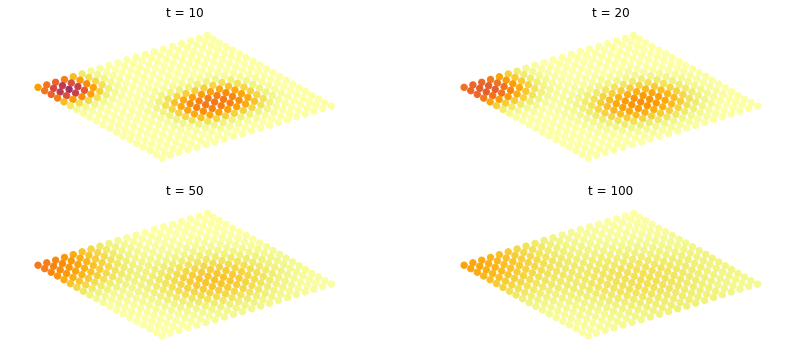

In [100]:
plt.figure(figsize=(7*2, 3*2))
i = 1
for t in [10, 20, 50, 100]:
    plt.subplot(2, 2, i)
    gridG = nx.grid_graph((20, 20))
    nx.draw_kamada_kawai(
        gridG,
        cmap=plt.cm.inferno_r,
        vmin=0, vmax=3,
        width=0,
        node_size=40,
        node_color=phi_t(A, phi0, C, t))
    plt.title('t = {}'.format(t))
    i += 1

### Task 5. Flow graph on biased random walk (2 points)

In this task, we consider a concept of flow graphs, namely weighted networks where dynamics flows are embedded into the link weight. Flow graphs provide an integrated representation of the structure and dynamics of the system, which can then be analyzed with standard tools of network science. Recall that an unbiased random walk uses a transition matrix $P$ to calculate distribution vector $p(t)$

$$p(t+1) = P^\top p(t)$$

$$P = D^{-1}A$$

where $D$ is a degree matrix. Thereby, the probability to jump from $i$ to $j$ is 

$$P_{ij} = \frac{A_{ij}}{d_i}$$

That is, a walker select the next node uniformly from nearest neighbors. 

A biased random walk is defined as follows. Let each node $i$ be given a definite positive attribute $\alpha_i$. Then a walker located at node $i$ decides to jump onto one of its neighbors, say $j$, with a probability proportional to $\alpha_jA_{ij}$. Hence, the probability to jump from $i$ to $j$ is given by

$$P_{ij} = \frac{\alpha_j A_{ij}}{\sum_k \alpha_k A_{ik}}$$

The usefull property of a biased random walk is that it coincides with an unbiased random walks on a _flow graph_

$$A'_{ij} = \alpha_i A_{ij} \alpha_j$$

Let us build this graph and look at its structure.

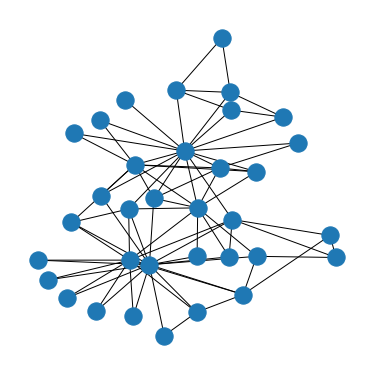

In [101]:
plt.figure(figsize=(5, 5))
G = nx.karate_club_graph()
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos=pos)

Build a few flow graphs using some centralities: degree, betweenness, eigenvalue.

Write a function `degree_flow_graph` that takes a graph and returns a flow graph where $\alpha_i$ is a degree centrality value of a node $i$. All weights are bounded by $\alpha_i / \max(\alpha)$, that is the largest weight is 1.

Functions `betweenness_flow_graph` and `eigenvector_flow_graph` have the same form, they are based on betweenness and eigenvalue centrality respectively.

In [175]:
def degree_flow_graph(G):
    
    centeralites = degree_centrality(G)
    tmp_max = 0
    A = nx.to_numpy_array(G)
    r , c= A.shape
    A_ = np.zeros(A.shape)
    for i in range(0,r):
      for j in range(0,c):
        A_[i][j] = centeralites[i] * A[i][j]  *  centeralites[j]
        if (A_[i][j] > tmp_max):
          tmp_max = A_[i][j]
    for i in range(0,r):
      for j in range(0,c):
         A_[i][j] = A_[i][j]/tmp_max
    G_ = nx.from_numpy_matrix(A_)
    return G_

    # YOUR CODE HERE
    #raise NotImplementedErro

In [176]:
degreeG = degree_flow_graph(G)
assert len(G) == len(degreeG)
d_weight = np.array([d['weight'] for (u,v,d) in degreeG.edges(data=True)])
assert round(d_weight.sum(), 4) == 17.8431
assert round(d_weight[76], 4) == 0.5
assert round(d_weight[33], 4) == 0.0588
assert round(d_weight[31], 4) == 0.5882

In [177]:
def betweenness_flow_graph(G):

    centeralites = betweenness_centrality(G)
    tmp_max = 0
    A = nx.to_numpy_array(G)
    r , c= A.shape
    A_ = np.zeros(A.shape)
    for i in range(0,r):
      for j in range(0,c):
        A_[i][j] = centeralites[i] * A[i][j]  *  centeralites[j]
        if (A_[i][j] > tmp_max):
          tmp_max = A_[i][j]
    for i in range(0,r):
      for j in range(0,c):
         A_[i][j] = A_[i][j]/tmp_max
    G_ = nx.from_numpy_matrix(A_)
    return G_

    # YOUR CODE HERE
    #raise NotImplementedErro
    # YOUR CODE HERE
    #raise NotImplementedError()

In [178]:
betweennessG = betweenness_flow_graph(G)
assert len(G) == len(betweennessG)
b_weight = np.array([d['weight'] for (u,v,d) in betweennessG.edges(data=True)])
assert round(b_weight.sum(), 4) == 7.5463
assert round(b_weight[1], 4) == 1
assert round(b_weight[33], 4) == 0.1571
assert round(b_weight[31], 4) == 0.0041

In [222]:
def eigenvector_flow_graph(G):
    centeralites = eigenvector_centrality(G)
    tmp_max = 0.0
    A = nx.to_numpy_array(G)
    r , c= A.shape
    A_ = np.zeros(A.shape)
    for i in range(0,r):
      for j in range(0,c):
        A_[i][j] = centeralites[i] * A[i][j]  *  centeralites[j]
        if (A_[i][j] >= tmp_max):
          tmp_max = A_[i][j]
    for i in range(0,r):
      for j in range(0,c):
         A_[i][j] = A_[i][j]/tmp_max
    G_ = nx.from_numpy_matrix(A_)
    return G_
    # YOUR CODE HERE
    #raise NotImplementedError()

In [223]:
eigenvectorG = eigenvector_flow_graph(G)
e_weight = np.array([d['weight'] for (u,v,d) in eigenvectorG.edges(data=True)])

print (round(e_weight.sum(), 4))
print (round(e_weight[75], 4))
print (round(e_weight[33], 4))
print (round(e_weight[31], 4))

29.1809
0.5117
0.1544
0.8495


In [182]:
eigenvectorG = eigenvector_flow_graph(G)
assert len(G) == len(eigenvectorG)
e_weight = np.array([d['weight'] for (u,v,d) in eigenvectorG.edges(data=True)])
assert round(e_weight.sum(), 4) == 29.1822
assert round(e_weight[75], 4) == 0.5117
assert round(e_weight[33], 4) == 0.1544
assert round(e_weight[31], 4) == 0.8496

AssertionError: ignored

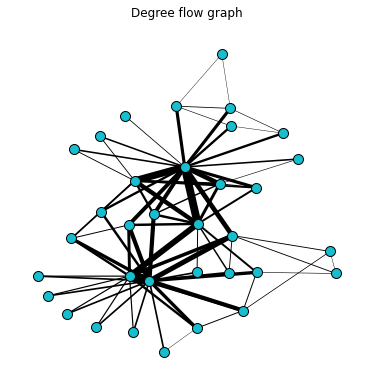

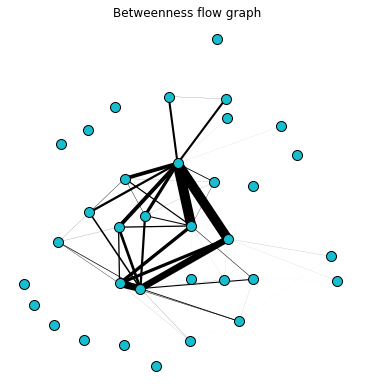

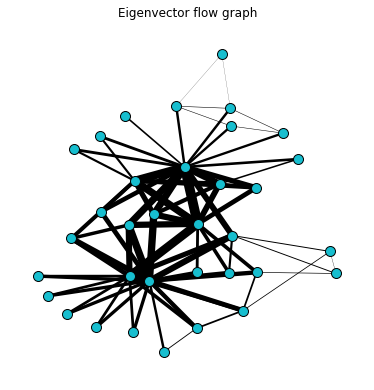

In [191]:
cases = [[degreeG, d_weight, 10, 'Degree'], 
         [betweennessG, b_weight, 10, 'Betweenness'], 
         [eigenvectorG, e_weight, 10, 'Eigenvector']]
for graph, weight, scale, title in cases:
    plt.figure(figsize=(5, 5))
    nx.draw(graph, 
            pos,
            node_size=100,
            edgecolors='black',
            node_color='tab:cyan',
            width=weight*scale)
    plt.title('{} flow graph'.format(title))
    plt.show()

Using unbiased random walk on an undirected graph, a probability of being on a node converges to a limit distribution vector

$$\lim_{t \to \infty} p(t) = \pi$$

$$\pi_i = \frac{d_i}{\sum_j d_j}$$

Similarly using biased random walks, it converges to a limit distribution vector

$$\pi_i' = \frac{\sum_j \alpha_i A_{ij} \alpha_j}{\sum_{i,j} \alpha_i A_{ij} \alpha_j}$$

Let us check this fact using an eigenvector flow graph.

Write a function `k_limit_distribution` that takes a graph, a number of iterations `k` and returns a tuple of 2 np.arrays:
* np.array of shape `(k+1, n)` where `n` is a number of nodes. i-th row contains distribution at time moment `t=i`. Here is a uniform distribution at `t=0`.
* np.array with limit distribution

In [ ]:
def k_limit_distribution(G, k):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
K = 10
k_d, limit_d = k_limit_distribution(eigenvectorG, K)
assert k_d.shape == (11, 34)
assert k_d[0].sum() == 1
assert k_d.sum() == 11
assert round(k_d[8, 8], 4) == 0.0528
assert round(k_d[0, 13], 4) == 0.0294

In [ ]:
plt.figure(figsize=(6,6))
for k, alpha in enumerate(np.linspace(0.3, 0.9, 9)):
    plt.plot(k_d[k], color='tab:orange', alpha=alpha)
plt.plot(k_d[-1], color='tab:orange', label='distribution at t={}'.format(K))
plt.plot(limit_d, '.', color='black', label='limit distribution');
plt.legend()
plt.title('Convergence of distribution')
plt.show()